In [0]:
from google.colab import drive
from google.colab import files
drive.mount('/content/gdrive')
!ls "gdrive/My Drive/Skripsi"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Dataset  Testlabel.csv	Trainlabel.csv


In [0]:
!pip install git+git://github.com/albertbup/deep-belief-network.git@master_gpu
!pip install -U git+https://github.com/scikit-learn-contrib/imbalanced-learn.git
  
print(__doc__)
from PIL import Image
import natsort
import numpy as np
import pandas as pd
import tensorflow as tf
from os import listdir
import cv2
from matplotlib import pyplot as plt
import skimage.io as io
from sklearn.model_selection import train_test_split
from sklearn.metrics.classification import accuracy_score
from dbn.tensorflow import SupervisedDBNClassification
from skimage.feature import hog
from skimage import data, exposure
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE,ADASYN

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

  Cloning git://github.com/albertbup/deep-belief-network.git (to revision master_gpu) to /tmp/pip-req-build-q0gtp4qm
  Running command git clone -q git://github.com/albertbup/deep-belief-network.git /tmp/pip-req-build-q0gtp4qm
  Running command git checkout -b master_gpu --track origin/master_gpu
  Switched to a new branch 'master_gpu'
  Branch 'master_gpu' set up to track remote branch 'master_gpu' from 'origin'.
     |████████████████████████████████| 377.0MB 57kB/s 
  Created wheel for deep-belief-network: filename=deep_belief_network-1.0.3-cp36-none-any.whl size=13464 sha256=1ea9b803c9ca752066c2487b8dcd639a300b776142edf1bc80e5d57657331b28
  Stored in directory: /tmp/pip-ephem-wheel-cache-5b79sqob/wheels/fe/5a/c7/18fc337ca5590a8b7c74c17ddba7a63935ce7a5bafb6cdec02
Successfully built deep-belief-network
  Cloning https://github.com/scikit-learn-contrib/imbalanced-learn.git to /tmp/pip-req-build-nkqyqedm
  Running command git clone -q https://github.com/scikit-learn-contrib/imbalanced-

W0822 14:25:11.918140 139883466995584 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/dbn/tensorflow/models.py:19: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

Using TensorFlow backend.


In [0]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

In [0]:
# daftar label
trainlabel= pd.read_csv('gdrive/My Drive/Skripsi/Trainlabel.csv')
testlabel= pd.read_csv('gdrive/My Drive/Skripsi/Testlabel.csv')
# daftar citra yang diurutkan
path_train= 'gdrive/My Drive/Skripsi/Dataset/Train/'
path_test= 'gdrive/My Drive/Skripsi/Dataset/Test/'
dir_train = natsort.natsorted(listdir(path_train))
dir_test = natsort.natsorted(listdir(path_test))
# hapus citra yang error
available_image_train = set(dir_train).intersection(set(trainlabel['Name']))
available_image_test = set(dir_test).intersection(set(testlabel['Name']))

In [0]:
# list citra
images_train = []
images_test = []
i=1
j=1
#persentase ukuran gambar yang diinginkan
skala=25 #persen

print('==================================================')
print('Mulai Preprocessing dan Segmentasi data training!')
print('==================================================')
for img in dir_train:
    # buka citra
    im_train = cv2.imread(path_train + img,0)
    width_train = int(im_train.shape[1] * skala / 100)
    height_train = int(im_train.shape[0] * skala / 100)
    dim_train = (width_train, height_train)
    # resize image
    shrink_train = cv2.resize(im_train, dim_train, interpolation = cv2.INTER_AREA)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    histeq_train=clahe.apply(shrink_train)
    preprocess_train= cv2.fastNlMeansDenoising(histeq_train,None,5,7,21)
    closing_train = cv2.morphologyEx(preprocess_train, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(12,12)))
    th_train= cv2.adaptiveThreshold(closing_train,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,13,2)
    fd_train, hog_image_train = hog(th_train, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=False)
    data_train= np.array(fd_train)
    #ubah ukuran citra menjadi (3*256*256)
    flattened_train = data_train.flatten() 
    # tambahkan citra ke list
    images_train.append(flattened_train) 
    print("Preprocessing dan Segmentasi data training...",(i,len(dir_train)))
    i=i+1
print('Preprocessing dan Segmentasi Selesai!')
print(' ')
print('==================================================')
print('Mulai Preprocessing dan Segmentasi data testing!')
print('==================================================')
for img in dir_test:
    # buka citra
    im_test = cv2.imread(path_test + img,0)
    width_test = int(im_test.shape[1] * skala / 100)
    height_test = int(im_test.shape[0] * skala / 100)
    dim_test = (width_test, height_test)
    # resize image
    shrink_test = cv2.resize(im_test, dim_test, interpolation = cv2.INTER_AREA)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    histeq_test=clahe.apply(shrink_test)
    preprocess_test= cv2.fastNlMeansDenoising(histeq_test,None,5,7,21)
    closing_test = cv2.morphologyEx(preprocess_test, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(12,12)))
    th_test= cv2.adaptiveThreshold(closing_test,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,13,2)
    fd_test, hog_image_test = hog(th_test, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=False)
    data_test = np.array(fd_test)
    # ubah ukuran citra menjadi (3 * 256 * 256)
    flattened_test = data_test.flatten()
    # tambahkan citra ke list
    images_test.append(flattened_test) 
    print("Preprocessing dan Segmentasi data testing...",(j,len(dir_test)))
    j=j+1
print('Preprocessing dan Segmentasi Selesai!')

Mulai Preprocessing dan Segmentasi data training!
Preprocessing dan Segmentasi data training... (1, 413)
Preprocessing dan Segmentasi data training... (2, 413)
Preprocessing dan Segmentasi data training... (3, 413)
Preprocessing dan Segmentasi data training... (4, 413)
Preprocessing dan Segmentasi data training... (5, 413)
Preprocessing dan Segmentasi data training... (6, 413)
Preprocessing dan Segmentasi data training... (7, 413)
Preprocessing dan Segmentasi data training... (8, 413)
Preprocessing dan Segmentasi data training... (9, 413)
Preprocessing dan Segmentasi data training... (10, 413)
Preprocessing dan Segmentasi data training... (11, 413)
Preprocessing dan Segmentasi data training... (12, 413)
Preprocessing dan Segmentasi data training... (13, 413)
Preprocessing dan Segmentasi data training... (14, 413)
Preprocessing dan Segmentasi data training... (15, 413)
Preprocessing dan Segmentasi data training... (16, 413)
Preprocessing dan Segmentasi data training... (17, 413)
Preproc

In [0]:
! pip install smote_variants

     |████████████████████████████████| 133kB 5.1MB/s 
  Created wheel for minisom: filename=MiniSom-2.1.9-cp36-none-any.whl size=6676 sha256=11cec0925a168ce65af08f10b660bfaab5fd0ce9f2d67a49f5906e519b998db3
  Stored in directory: /root/.cache/pip/wheels/f9/70/2e/5fe380eaea27f5de4843c767908d5221b0f9a12247cfb62de1
  Created wheel for statistics: filename=statistics-1.0.3.5-cp36-none-any.whl size=7454 sha256=e020ea97728599e7c4f2309beaf124c90de72fbe6ce1b2e6c582d14f03488082
  Stored in directory: /root/.cache/pip/wheels/75/55/90/73aa7662bfb4565b567618547a275f01372a678ca92ecd64f3
Successfully built minisom statistics


In [24]:
# masukan model
x_train = np.array(images_train)        
y_train = np.array(trainlabel.Grade)
x_test = np.array(images_test)        
y_test = np.array(testlabel.Grade)

# split data
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
# object pelatihan model
classifier = SupervisedDBNClassification(hidden_layers_structure=[256,256],
                                         learning_rate_rbm=0.01,
                                         learning_rate=0.01,
                                         n_epochs_rbm=100,
                                         n_iter_backprop=1000,
                                         batch_size=64, 
                                         activation_function='sigmoid',
                                         dropout_p=0.2,)

#scores = []
#folds = StratifiedKFold(n_splits=7)
#for train_index, test_index in folds.split(x_train,y_train):
    #print("Index Data Training = ",train_index)
    #print("Index Data Testing = ",test_index)
    #xtr, xts, ytr, yts = x_train[train_index], x_train[test_index],y_train[train_index], y_train[test_index]
    #classifier.fit(xtr, ytr)
    #scores.append(classifier.score(xts, yts))

#scoreout=cross_val_score(classifier, digits.data, digits.target,cv=7)
#rerata=np.average(scores)
#print("Score Model = ",rerata)

#latih model
classifier.fit(x_train, y_train)

[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 1949.127214
>> Epoch 2 finished 	RBM Reconstruction error 1184.673027
>> Epoch 3 finished 	RBM Reconstruction error 985.516126
>> Epoch 4 finished 	RBM Reconstruction error 790.094080
>> Epoch 5 finished 	RBM Reconstruction error 733.052435
>> Epoch 6 finished 	RBM Reconstruction error 681.075844
>> Epoch 7 finished 	RBM Reconstruction error 690.875145
>> Epoch 8 finished 	RBM Reconstruction error 688.519312
>> Epoch 9 finished 	RBM Reconstruction error 669.675582
>> Epoch 10 finished 	RBM Reconstruction error 684.596559
>> Epoch 11 finished 	RBM Reconstruction error 674.163925
>> Epoch 12 finished 	RBM Reconstruction error 659.480463
>> Epoch 13 finished 	RBM Reconstruction error 646.824785
>> Epoch 14 finished 	RBM Reconstruction error 663.916597
>> Epoch 15 finished 	RBM Reconstruction error 634.572594
>> Epoch 16 finished 	RBM Reconstruction error 617.555059
>> Epoch 17 finished 	RBM Reconstruction error 631.3

SupervisedDBNClassification(batch_size=64, dropout_p=0.2,
                            idx_to_label_map={0: 3, 1: 2, 2: 4, 3: 1, 4: 0},
                            l2_regularization=1.0,
                            label_to_idx_map={0: 4, 1: 3, 2: 1, 3: 0, 4: 2},
                            learning_rate=0.01, n_iter_backprop=1000,
                            verbose=True)

Skor =  0.49514563106796117
Done.
Accuracy: 0.495146
              precision    recall  f1-score   support

           0       0.48      0.41      0.44        34
           1       0.00      0.00      0.00         5
           2       0.43      0.78      0.56        32
           3       0.77      0.53      0.62        19
           4       0.67      0.15      0.25        13

    accuracy                           0.50       103
   macro avg       0.47      0.37      0.38       103
weighted avg       0.52      0.50      0.47       103

Confusion matrix, without normalization
[[14  0 19  1  0]
 [ 3  0  2  0  0]
 [ 6  0 25  1  0]
 [ 3  0  5 10  1]
 [ 3  0  7  1  2]]
Normalized confusion matrix
[[0.41 0.   0.56 0.03 0.  ]
 [0.6  0.   0.4  0.   0.  ]
 [0.19 0.   0.78 0.03 0.  ]
 [0.16 0.   0.26 0.53 0.05]
 [0.23 0.   0.54 0.08 0.15]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


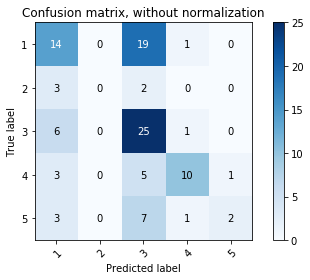

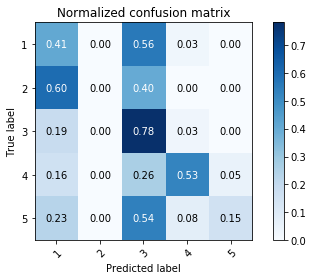

In [25]:
# simpan model
classifier.save('model.pkl')
# load model
#classifier = SupervisedDBNClassification.load('model.pkl')

#score
Nilai_model=classifier.score(x_test, y_test)
print("Skor = ",Nilai_model)
#plot=classifier.proof()

#akurasi
y_pred=classifier.predict(x_test)
print('Done.\nAccuracy: %f' % accuracy_score(y_test, y_pred))

#presisi, F1 score, recall
print(classification_report(y_test, y_pred))

#confusion matrix
np.set_printoptions(precision=2)
class_names = ['1','2','3','4','5']
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [0]:
print(x_train.shape,y_train.shape)
print(x_sm.shape,y_sm.shape)

(413, 23584) (413,)
(529, 23584) (529,)
